### Import all necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week
from sklearn.model_selection import train_test_split
from itertools import product

import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean
import pandas_ta as ta
import warnings
from sklearn.preprocessing import PolynomialFeatures
from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.optimize import minimize
import pickle
import os
# Suppress all warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#!pip install yfinance==0.2.59
#!which python   

In [3]:
import yfinance
print(yfinance.__version__)

0.2.59


In [4]:
import sys
print(sys.version)


3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]


### Evaluation Metrics
- MAE, RMSE, MASE

In [5]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    
    Returns:
    - MASE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    naive_forecast = np.roll(y_true, shift=1)  # Naïve forecast: previous value as the next
    naive_forecast[0] = y_true[0]  # First value remains the same to avoid shifting issues
    naive_mae = np.mean(np.abs(y_true - naive_forecast))  # Baseline error
    mase = np.mean(np.abs(y_true - y_pred)) / naive_mae if naive_mae != 0 else np.nan  # Avoid division by zero
    return mase


def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
  
    #print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    epsilon=1e-8
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    mase_original = mean_absolute_scaled_error(y_true_original , y_pred_original) 
    
    #print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original, mase_original

### Functions from Data splitting, Data scaling, Hyp-params optimization, Full-model Training

In [6]:
# Step 1 & 2: Scale and Split the data
def prepare_data(data, max_lag, windows, 
                 fit_and_split = True, feature_scaler=None, target_scaler=None, 
                 poly=None, svd=None, feature_columns=None):
    """
    If fit_and_split=True:
        - Fits poly, svd, scalers, and splits data into train/test
    If fit_and_split=False:
        - Uses pre-fitted poly, svd, scalers to transform data without splitting
    """
    data = data.copy()
    
    # Add seasonality features
    data['Month'] = data.index.month
    data['Weekday'] = data.index.weekday
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    
    # Generate lagged log return features
    for lag in range(1, max_lag + 1):
        data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)

    # Generate SMA features 
    for window in windows:
        data[f'SMA_{window}'] = data['Log_Return'].shift(1).rolling(window=window).mean()

    # Drop rows with NaN values due to lagging and SMA calculation
    data = data.dropna()
    if fit_and_split:
        # Extract feature columns
        feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                          [f'SMA_{window}' for window in windows] + \
                          [ 'Month', 'Weekday', 'Quarter', 'WeekOfYear']
    elif feature_columns is None:
        raise ValueError("feature_columns must be provided when fit_and_split=False")
        
    # Extract features and target
    X = data[feature_columns].values
    y = data['Log_Return'].values
    
    if fit_and_split:
        poly_degree = 2
        poly = PolynomialFeatures(degree=poly_degree, interaction_only=True, include_bias=False)
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        svd_components = 95
        svd = TruncatedSVD(n_components=svd_components, random_state=42)
        # Create polynomial features
        
        X_poly = poly.fit_transform(X)

        # Identify indices of original features in X_poly
        feature_names = poly.get_feature_names_out()
        original_feature_indices = [i for i, name in enumerate(feature_names) if name in feature_columns]

        # Extract original features from X_poly
        X_poly_original = X_poly[:, original_feature_indices]

        # Extract interaction terms (residuals)
        X_poly_residual = np.delete(X_poly, original_feature_indices, axis=1)

        # Apply Truncated SVD for dimensionality reduction
        X_svd = svd.fit_transform(X_poly_residual)

        # Combine original + SVD features
        X_combined = np.concatenate([X_poly_original, X_svd], axis=1)
        
        # Create scalers for features and target     
        X_scaled = feature_scaler.fit_transform(X_combined)
        #y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()
        y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))
        
        train_size = int(len(data) * 0.75)
        X_train_scaled, X_test_scaled = X_scaled[:train_size], X_scaled[train_size:]
        y_train_scaled, y_test_scaled = y_scaled[:train_size], y_scaled[train_size:]
        
        return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler, poly, svd, feature_columns
        
    else:
        X_poly = poly.transform(X)
        feature_names = poly.get_feature_names_out()
        original_feature_indices = [i for i, name in enumerate(feature_names) if name in feature_columns]
        # Extract original features from X_poly
        X_poly_original = X_poly[:, original_feature_indices]

        # Extract interaction terms (residuals)
        X_poly_residual = np.delete(X_poly, original_feature_indices, axis=1)
        
        # Apply Truncated SVD for dimensionality reduction
        X_svd = svd.transform(X_poly_residual)

        # Combine original + SVD features
        X_combined = np.concatenate([X_poly_original, X_svd], axis=1)
        
        X_scaled = feature_scaler.transform(X_combined)
        #y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()
        y_scaled = target_scaler.transform(y.reshape(-1, 1))
        
        return X_scaled, y_scaled, feature_scaler, target_scaler, poly, svd, feature_columns


# Step 3: Model training with hyperparameter tuning using Bayesian Search CV
def model_training(train_data_scaled, y_train_scaled):
    """
    Trains an OLS regression model using Bayesian Search CV for hyperparameter optimization.
    
    Parameters:
    - train_data_scaled: Scaled training data (features).
    - y_train: Training data (target).
    
    Returns:
    - best_model: Best OLS model based on Bayesian search.
    - best_params: Best parameters found during search.
    """
    # Ensure data is in the right format
    train_data_scaled = train_data_scaled.astype(float)
    y_train_scaled = y_train_scaled.astype(float)

    # Define a custom wrapper for OLS regression compatible with BayesSearchCV
    class OLSWrapper:
        def __init__(self, cov_type='HC0', use_t=True, method='pinv'):
            self.cov_type = cov_type
            self.use_t = use_t
            self.method = method
            self.model = None

        def fit(self, X, y):
            self.model = sm.OLS(y, X).fit(cov_type=self.cov_type, use_t=self.use_t, method=self.method)
            return self

        def predict(self, X):
            return self.model.predict(X)

        def score(self, X, y):
            predictions = self.predict(X)
            # Use negative MAE as score for BayesSearchCV (higher is better)
            mae = np.mean(np.abs(y - predictions))
            return -mae

        # Fix: Implement get_params and set_params for compatibility with BayesSearchCV
        def get_params(self, deep=True):
            return {'cov_type': self.cov_type, 'use_t': self.use_t, 'method': self.method}

        def set_params(self, **params):
            for key, value in params.items():
                setattr(self, key, value)
            return self

    # Define the hyperparameter space for Bayesian optimization
    param_space = {
        'cov_type': Categorical(['HC0', 'HC1']),
        'use_t': Categorical([True, False]),
        'method': Categorical(['pinv', 'qr'])
    }

    # Initialize Bayesian search
    bayes_search = BayesSearchCV(
        OLSWrapper(),
        param_space,
        n_iter=30,                   # Number of iterations (adjust based on time constraints)
        cv=5,                        # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )

    # Perform Bayesian search
    bayes_search.fit(train_data_scaled, y_train_scaled)

    # Extract best model and parameters
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_

    print("Best Model Parameters:", best_params)

    return best_model, best_params


# Step 4: Retraining model
def train_final_model(data, max_lag, sma_windows,feature_scaler, target_scaler, 
                      poly, svd, feature_columns, best_params):
        
    X_full_scaled,y_full_scaled, _ , _, _, _, _ = prepare_data(data, max_lag, sma_windows, 
                     fit_and_split = False, feature_scaler=feature_scaler, target_scaler=target_scaler, 
                     poly=poly, svd=svd, feature_columns=feature_columns)

    final_model = sm.OLS(y_full_scaled, X_full_scaled).fit(
        cov_type=best_params['cov_type'],
        use_t=best_params['use_t'],
        method=best_params['method']
    )

    return final_model

### Method for future days forecasting

In [7]:
def forecast_future(data, final_model, feature_scaler, target_scaler,poly, svd, feature_cols, max_lag, windows, start_date, end_date):
    """
    Recursively forecasts future log returns using lag, SMA, and time-based features.
    Forecasted values are appended back into the dataset to allow rolling feature generation.
    """
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days only
    data = data.copy()

    # Ensure only necessary column is there and index is sorted
    data = data[['Log_Return']].copy()
    data = data.sort_index()

    forecasted_values = []

    for forecast_date in forecast_dates:
        # Dynamically add forecast row placeholder
        if forecast_date not in data.index:
            data.loc[forecast_date] = np.nan

        # Get the index position of forecast_date
        idx = data.index.get_loc(forecast_date)

        # Create a new feature row
        new_row = pd.DataFrame(index=[forecast_date])

        # Seasonality/time features using your suggested methods
        new_row['Month'] = forecast_date.month
        new_row['Weekday'] = forecast_date.weekday()
        new_row['Quarter'] = forecast_date.quarter
        new_row['WeekOfYear'] = forecast_date.isocalendar().week

        # Lag features
        for lag in range(1, max_lag + 1):
            lag_idx = idx - lag
            if lag_idx >= 0:
                new_row[f'Lagged_Log_Return_{lag}'] = data.iloc[lag_idx]['Log_Return']
            else:
                new_row[f'Lagged_Log_Return_{lag}'] = np.nan

        # SMA features
        for window in windows:
            start_idx = idx - window
            if start_idx >= 0:
                sma_vals = data.iloc[start_idx:idx]['Log_Return'].dropna()
                new_row[f'SMA_{window}'] = sma_vals.mean() if len(sma_vals) == window else np.nan
            else:
                new_row[f'SMA_{window}'] = np.nan

        # If any feature is NaN, skip this forecast
        if new_row.isnull().any(axis=1).values[0]:
            forecasted_values.append(np.nan)
            continue

        # Feature order must match training
        feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                          [f'SMA_{w}' for w in windows] + ['Month', 'Weekday', 'Quarter', 'WeekOfYear']

        # Transform features
        #X = feature_scaler.transform(new_row[feature_columns])

        input_features_poly = poly.transform(new_row[feature_columns])
        
        # Extract Original Features Explicitly
        feature_names = poly.get_feature_names_out()
        original_feature_indices = [i for i, name in enumerate(feature_names) if name in feature_cols]
        
        # Extract original features directly
        input_features_original = input_features_poly[:, original_feature_indices]
        
        # Extract interaction terms (residuals)
        input_features_residual = np.delete(input_features_poly, original_feature_indices, axis=1)
        
        # Apply SVD Transformation on Residuals
        input_features_svd = svd.transform(input_features_residual)
        
        # Combine Original Features + SVD Features
        input_features_combined = np.concatenate([input_features_original, input_features_svd], axis=1)
        
        # Scale the combined features
        X = feature_scaler.transform(input_features_combined)
        
        # Predict and inverse transform
        y_pred_scaled = final_model.predict(X)
        y_pred_original = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()[0]

        


        # Add forecasted value to the data for future feature generation
        data.loc[forecast_date, 'Log_Return'] = y_pred_original

        # Store and append prediction to forecasted values
        forecasted_values.append(y_pred_original)
        
    # Return DataFrame with forecasted values
    forecast_df = pd.DataFrame({'Forecasted_Log_Return': forecasted_values}, index=forecast_dates)
    return forecast_df


### Grouping forecast into monthly and weekly horizons

In [8]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [9]:
def plot_forecasted_returns(df_forecast):
    """
    Plots the forecasted log returns over time.
    
    Parameters:
    df_forecast (pd.DataFrame): DataFrame containing 'Date' and 'Forecasted_Log_Return' columns.
    """

    df_forecast.index = pd.to_datetime(df_forecast.index)
    
    # Plot the forecasted returns
    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast["Forecasted_Log_Return"], color='orange', linestyle='-', label="Forecasted Returns")
    
    plt.title("Forecasted Log Returns for 2024")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Log Return")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()

### To save and load the best hyper-params, scalers (feature and target), polynomial and svd scalers

In [10]:
def save_artifacts(paths, artifacts):
    for path, artifact in zip(paths, artifacts):
        with open(path, "wb") as f:
            pickle.dump(artifact, f)

def load_artifacts(paths):
    artifacts = []
    for path in paths:
        with open(path, "rb") as f:
            artifact = pickle.load(f)
            artifacts.append(artifact)
    return artifacts

In [11]:
def build_artifact_paths(ticker, root="Model_artifacts/OLS/2024", ensure_dirs=True):
    subdirs = {
        "best_params": "best_hyper_params",
        "feature_scaler": "feature_scalers",
        "target_scaler": "target_scalers",
        "poly": "polynomial_scalers",
        "svd": "svd_scalers",
        "feature_cols": "feature_cols"
    }

    paths = []
    for key, subdir in subdirs.items():
        full_dir = os.path.join(root, subdir)
        if ensure_dirs:
            os.makedirs(full_dir, exist_ok=True)
        filename = f"{ticker}_{key}.pkl"
        full_path = os.path.join(full_dir, filename)
        paths.append(full_path)

    return paths

In [12]:
def load_etf_data(ticker, start_date, end_date, data_dir="data/etfs"):
    path = os.path.join(data_dir, f"{ticker}.csv")
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    return df[(df.index >= start_date) & (df.index <= end_date)].copy()

## This is to save and load artifacts in same workflow

### Workflow which executes all the above methods

In [13]:
# Step 7: Main Function
def main(data, ticker):
    max_lag = 80
    windows = [5,10,50]
    
    # Scale and Split Data for Evaluation
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler, poly, svd, feature_cols = prepare_data(data, max_lag, windows, fit_and_split = True)

    # Train Model on Train Set 
    start_time = time.time()    
    best_model, best_params = model_training(X_train_scaled, y_train_scaled)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)
        
    # Evaluate Train-Test Performance
    train_rmse, train_mae, train_mase = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae, test_mase = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MASE : {train_mase:.4f} ")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MASE: {test_mase:.4f} ")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse,
                    "mase" : train_mase
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse,
                    "mase" : test_mase
                },
                "time":computaton_time
                
        }

    paths = build_artifact_paths(ticker)
        
    
    # Add actual artifacts
    artifacts = [best_params, feature_scaler, target_scaler, poly, svd, feature_cols]

    # Save Artifacts
    print(f"Saving best params and scalers for: {ticker}")
    save_artifacts(paths, artifacts)
    
    # Load Artifacts
    print(f"Loading best params and scalers for: {ticker}")
    loaded_artifacts = load_artifacts(paths)
    best_params_loaded, feature_scaler_loaded, target_scaler_loaded, poly_loaded, svd_loaded, feature_cols_loaded = loaded_artifacts

    final_model = train_final_model(data, max_lag, windows, feature_scaler_loaded, target_scaler_loaded, 
                      poly_loaded, svd_loaded, feature_cols_loaded, best_params_loaded)
    
    # Forecast Future (`2024`)
    future_predictions = forecast_future(data, final_model, feature_scaler_loaded, target_scaler_loaded, poly_loaded, svd_loaded, feature_cols_loaded, max_lag, windows, start_date="2024-01-01", end_date="2024-12-31" )

    print("Future Predictions:")
    print(future_predictions)
    
    return final_model, future_predictions, model_metrics

### Method to trigger the above worflow with input tickers and data loading method

Processing SMH...
                Close
Date                 
2000-06-05  42.031502
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 11.07 seconds
Train RMSE: 0.0210, Train MAE: 0.0148, Train MASE : 0.6883 
Test RMSE: 0.0219, Test MAE: 0.0162, Test MASE: 0.6922 
Saving best params and scalers for: SMH
Loading best params and scalers for: SMH
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.003141
2024-01-02               0.002707
2024-01-03               0.002245
2024-01-04               0.001766
2024-01-05               0.000842
2024-01-08               0.002371
2024-01-09               0.002188
2024-01-10               0.001688
2024-01-11               0.001005
2024-01-12               0.000364
2024-01-15               0.002159
2024-01-16               0.001343
2024-01-17               0.001445
2024-01-18               0.000683
2024-01-19               0.000

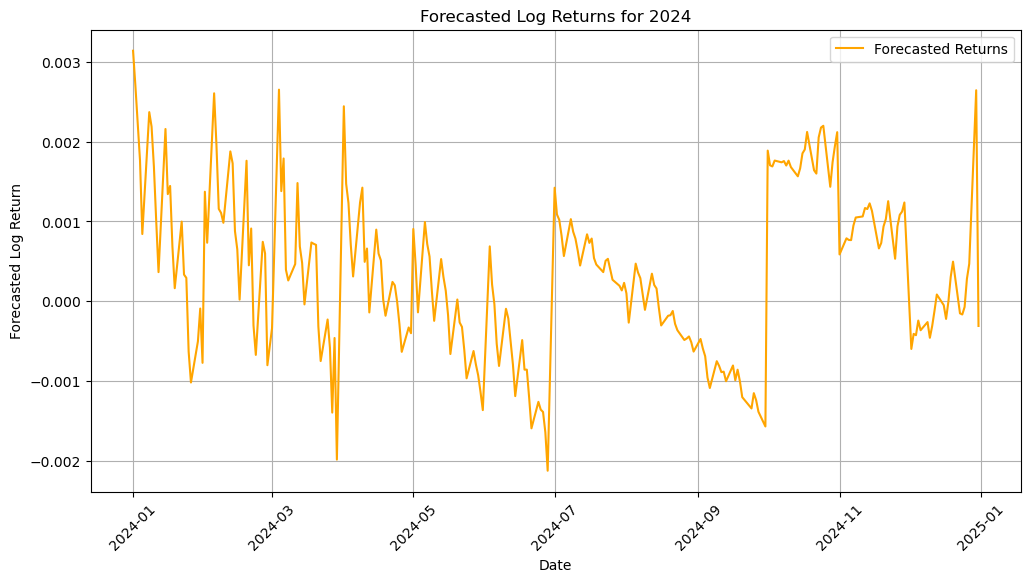

Processing SOXX...
                Close
Date                 
2001-07-13  20.021658
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC1'), ('method', 'pinv'), ('use_t', False)])
Computation Time: 8.39 seconds
Train RMSE: 0.0189, Train MAE: 0.0139, Train MASE : 0.6950 
Test RMSE: 0.0226, Test MAE: 0.0167, Test MASE: 0.6995 
Saving best params and scalers for: SOXX
Loading best params and scalers for: SOXX
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.002125
2024-01-02               0.001846
2024-01-03               0.001593
2024-01-04               0.001158
2024-01-05               0.000711
2024-01-08               0.001737
2024-01-09               0.001565
2024-01-10               0.001166
2024-01-11               0.000459
2024-01-12               0.000193
2024-01-15               0.001836
2024-01-16               0.000858
2024-01-17               0.001094
2024-01-18               0.000464
2024-01-19               0

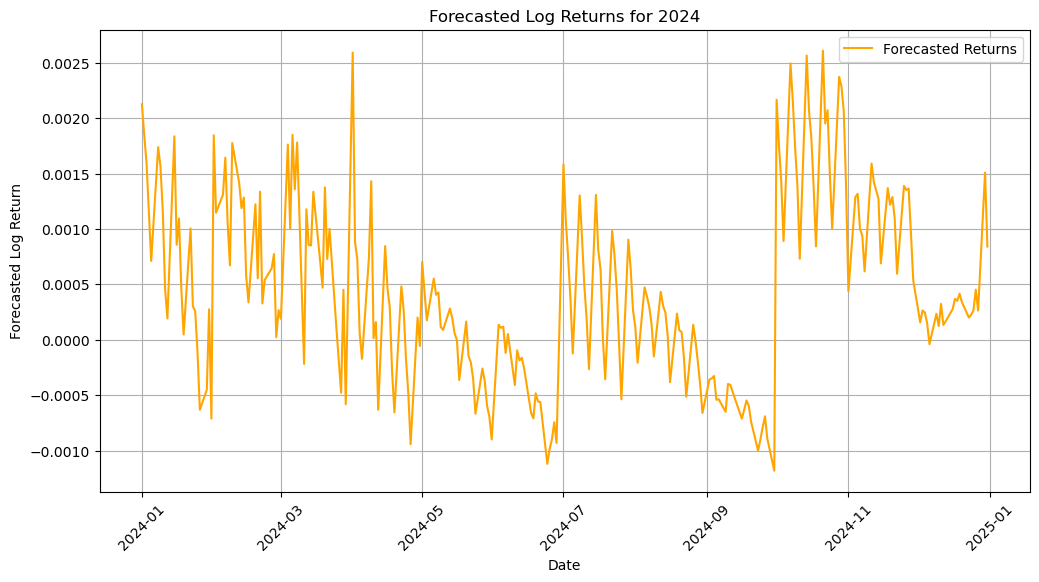

Processing PSI...
               Close
Date                
2005-06-23  4.565489
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 7.10 seconds
Train RMSE: 0.0171, Train MAE: 0.0127, Train MASE : 0.6890 
Test RMSE: 0.0240, Test MAE: 0.0179, Test MASE: 0.6905 
Saving best params and scalers for: PSI
Loading best params and scalers for: PSI
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.002220
2024-01-02               0.001577
2024-01-03               0.001378
2024-01-04               0.001285
2024-01-05               0.000313
2024-01-08               0.001810
2024-01-09               0.001352
2024-01-10               0.001354
2024-01-11               0.000774
2024-01-12              -0.000217
2024-01-15               0.002008
2024-01-16               0.001472
2024-01-17               0.001232
2024-01-18               0.000682
2024-01-19               0.000784


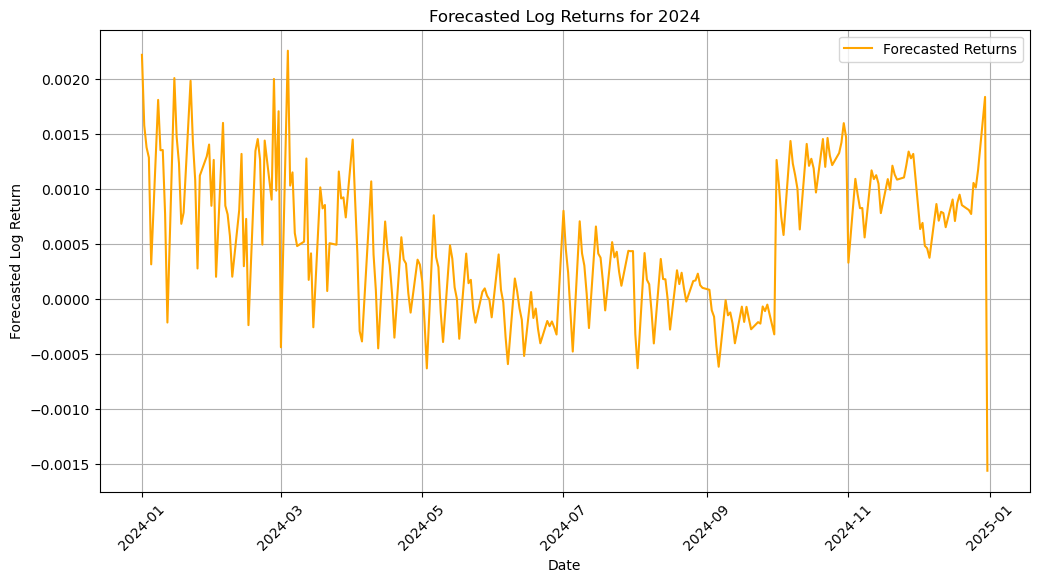

Processing XSD...
                Close
Date                 
2006-02-06  23.954132
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 7.08 seconds
Train RMSE: 0.0176, Train MAE: 0.0131, Train MASE : 0.6933 
Test RMSE: 0.0245, Test MAE: 0.0186, Test MASE: 0.6963 
Saving best params and scalers for: XSD
Loading best params and scalers for: XSD
Future Predictions:
            Forecasted_Log_Return
2024-01-01           1.520421e-03
2024-01-02           1.300420e-03
2024-01-03           6.237035e-04
2024-01-04           1.899095e-03
2024-01-05          -3.887423e-04
2024-01-08           1.437720e-03
2024-01-09           1.230761e-03
2024-01-10           6.349124e-04
2024-01-11           1.290724e-03
2024-01-12          -7.873799e-04
2024-01-15           1.655916e-03
2024-01-16           9.849629e-04
2024-01-17           9.291055e-04
2024-01-18           6.391110e-04
2024-01-19           1.012058e-

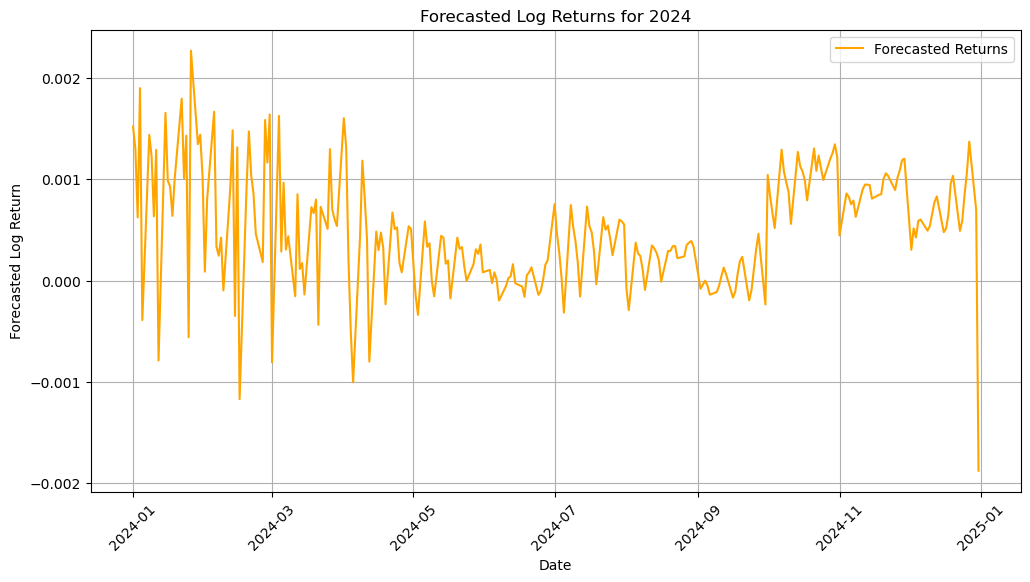

Processing IYW...
                Close
Date                 
2000-05-19  23.606707
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 7.56 seconds
Train RMSE: 0.0166, Train MAE: 0.0112, Train MASE : 0.6879 
Test RMSE: 0.0178, Test MAE: 0.0126, Test MASE: 0.6958 
Saving best params and scalers for: IYW
Loading best params and scalers for: IYW
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001758
2024-01-02               0.001670
2024-01-03               0.001114
2024-01-04               0.000694
2024-01-05               0.000783
2024-01-08               0.001070
2024-01-09               0.001000
2024-01-10               0.001124
2024-01-11               0.000618
2024-01-12              -0.000600
2024-01-15               0.001511
2024-01-16               0.000951
2024-01-17               0.000386
2024-01-18               0.000618
2024-01-19               0.0004

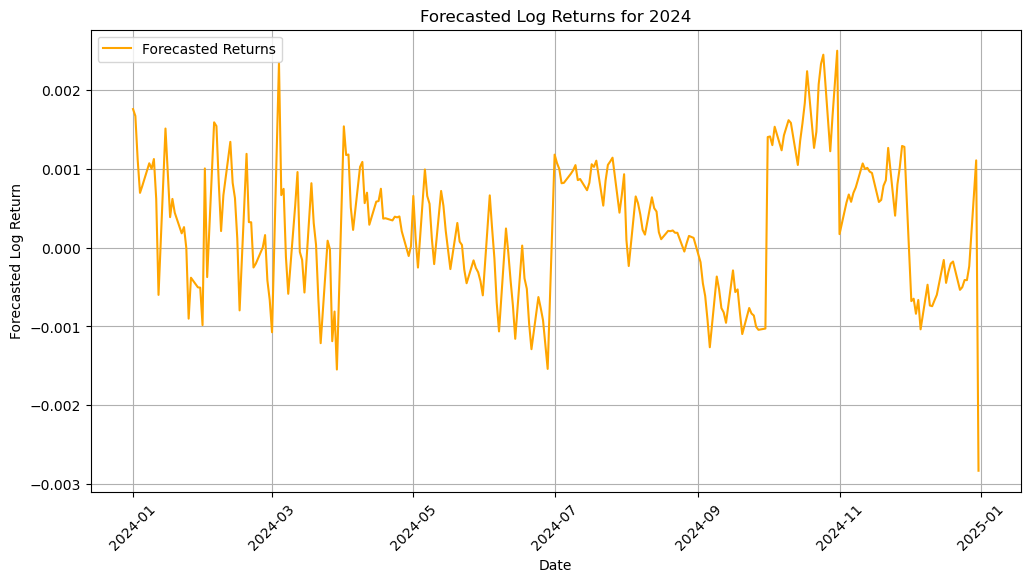

Processing XLK...
               Close
Date                
2000-01-03  41.48851
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 7.51 seconds
Train RMSE: 0.0154, Train MAE: 0.0104, Train MASE : 0.6790 
Test RMSE: 0.0173, Test MAE: 0.0122, Test MASE: 0.6985 
Saving best params and scalers for: XLK
Loading best params and scalers for: XLK
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001480
2024-01-02               0.001339
2024-01-03               0.001052
2024-01-04               0.000643
2024-01-05               0.000554
2024-01-08               0.000887
2024-01-09               0.000692
2024-01-10               0.000839
2024-01-11               0.000584
2024-01-12              -0.000392
2024-01-15               0.001051
2024-01-16               0.000889
2024-01-17               0.000352
2024-01-18               0.000317
2024-01-19               0.000319


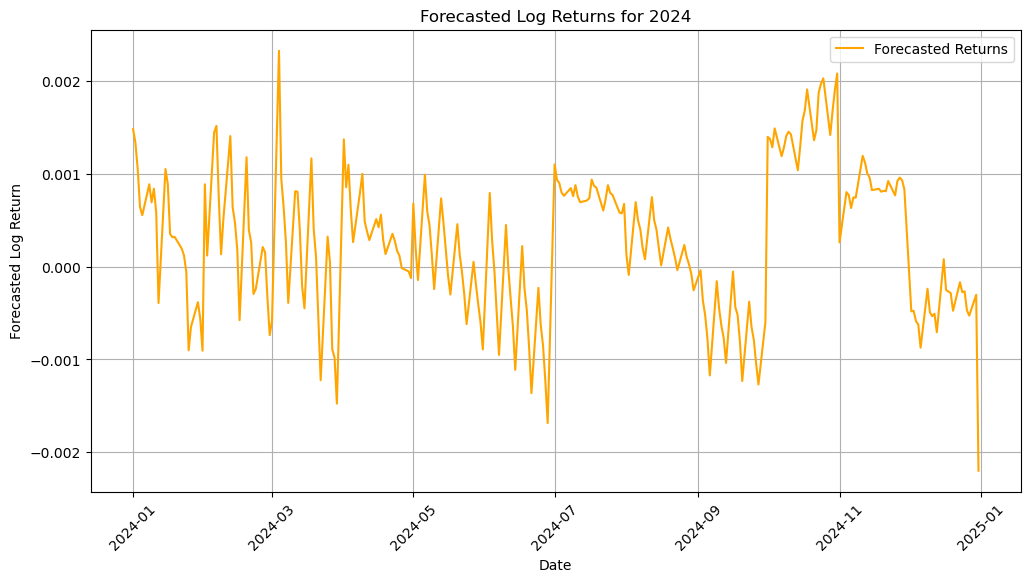

Processing VGT...
                Close
Date                 
2004-01-30  41.205193
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC1'), ('method', 'pinv'), ('use_t', False)])
Computation Time: 8.08 seconds
Train RMSE: 0.0126, Train MAE: 0.0089, Train MASE : 0.6849 
Test RMSE: 0.0177, Test MAE: 0.0126, Test MASE: 0.7043 
Saving best params and scalers for: VGT
Loading best params and scalers for: VGT
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000937
2024-01-02               0.000802
2024-01-03               0.000344
2024-01-04               0.000497
2024-01-05              -0.000175
2024-01-08               0.000710
2024-01-09               0.000454
2024-01-10               0.000464
2024-01-11               0.000274
2024-01-12              -0.000867
2024-01-15               0.000903
2024-01-16               0.000419
2024-01-17               0.000401
2024-01-18               0.000523
2024-01-19               0.00

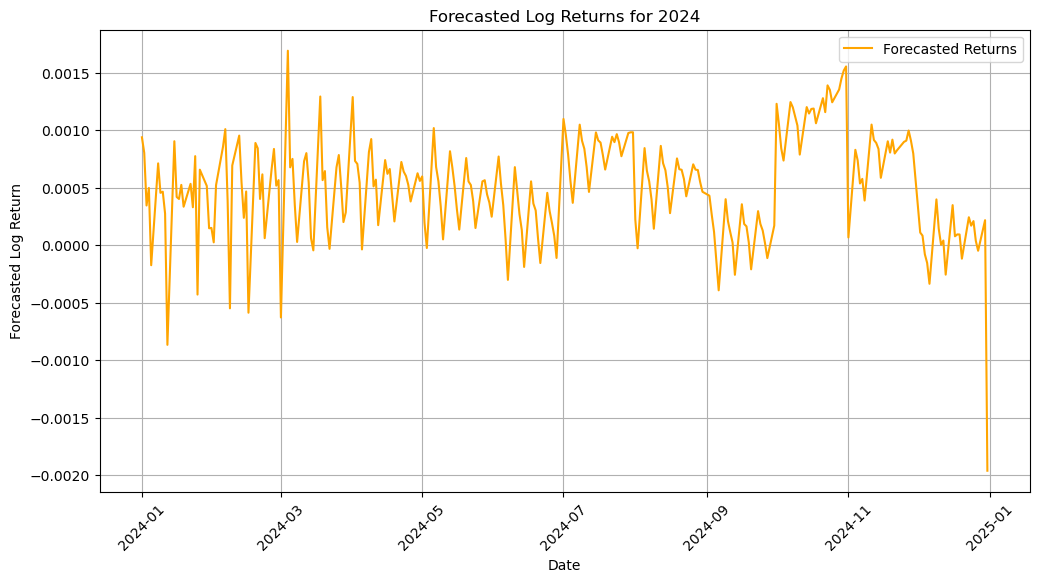

Processing QQQ...
                Close
Date                 
2000-01-03  80.314285
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 7.55 seconds
Train RMSE: 0.0165, Train MAE: 0.0111, Train MASE : 0.6805 
Test RMSE: 0.0163, Test MAE: 0.0115, Test MASE: 0.6992 
Saving best params and scalers for: QQQ
Loading best params and scalers for: QQQ
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001200
2024-01-02               0.001642
2024-01-03               0.001222
2024-01-04              -0.000283
2024-01-05               0.000635
2024-01-08               0.000803
2024-01-09               0.000567
2024-01-10               0.000556
2024-01-11               0.001009
2024-01-12              -0.000066
2024-01-15               0.001143
2024-01-16               0.000794
2024-01-17               0.000232
2024-01-18              -0.000003
2024-01-19               0.0009

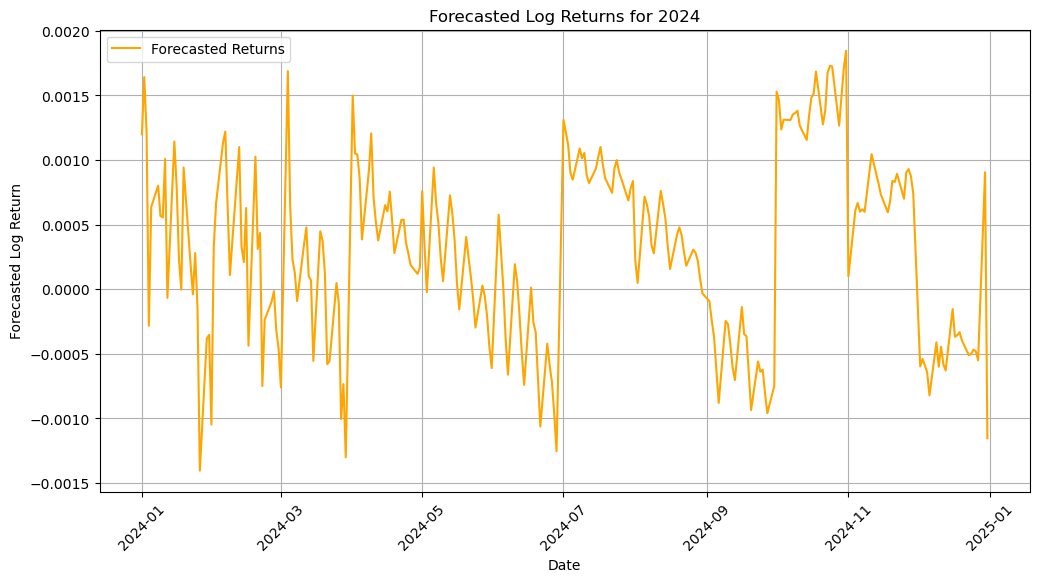

Processing IGM...
               Close
Date                
2001-03-19  7.933846
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 7.59 seconds
Train RMSE: 0.0144, Train MAE: 0.0101, Train MASE : 0.6854 
Test RMSE: 0.0176, Test MAE: 0.0124, Test MASE: 0.6998 
Saving best params and scalers for: IGM
Loading best params and scalers for: IGM
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001077
2024-01-02               0.001011
2024-01-03               0.000866
2024-01-04               0.000717
2024-01-05               0.000559
2024-01-08               0.000855
2024-01-09               0.000677
2024-01-10               0.000805
2024-01-11               0.000394
2024-01-12              -0.000075
2024-01-15               0.001117
2024-01-16               0.000675
2024-01-17               0.000512
2024-01-18               0.000606
2024-01-19               0.000124


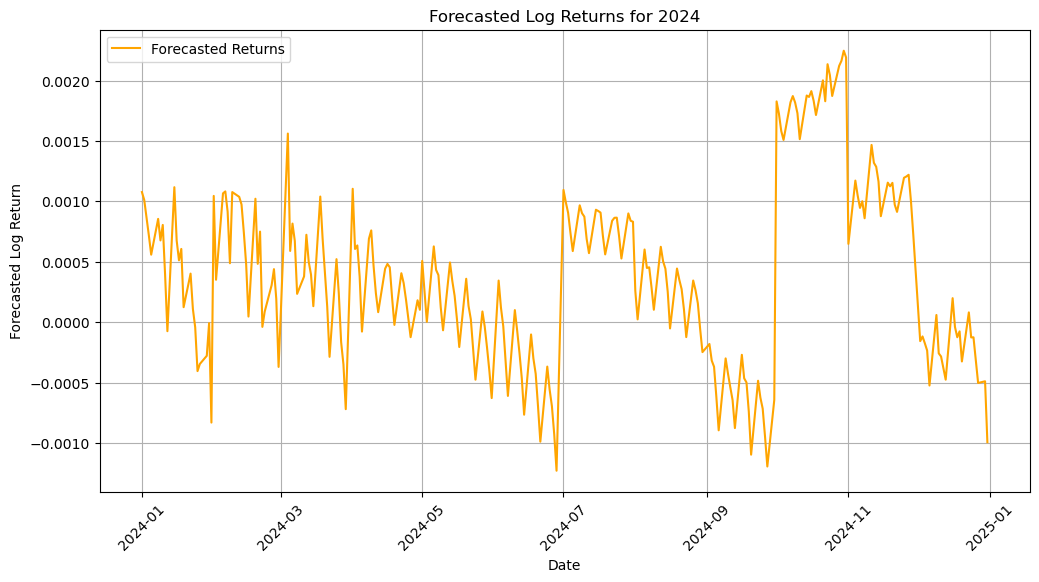

Processing IXN...
               Close
Date                
2001-11-26  7.813636
Index(['Close'], dtype='object')
Best Model Parameters: OrderedDict([('cov_type', 'HC0'), ('method', 'qr'), ('use_t', False)])
Computation Time: 7.56 seconds
Train RMSE: 0.0135, Train MAE: 0.0094, Train MASE : 0.6792 
Test RMSE: 0.0173, Test MAE: 0.0122, Test MASE: 0.6946 
Saving best params and scalers for: IXN
Loading best params and scalers for: IXN
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001293
2024-01-02               0.001302
2024-01-03               0.000593
2024-01-04               0.000662
2024-01-05               0.000279
2024-01-08               0.000939
2024-01-09               0.000688
2024-01-10               0.000641
2024-01-11               0.000136
2024-01-12              -0.000386
2024-01-15               0.000900
2024-01-16               0.000600
2024-01-17               0.000320
2024-01-18               0.000558
2024-01-19              -0.000180


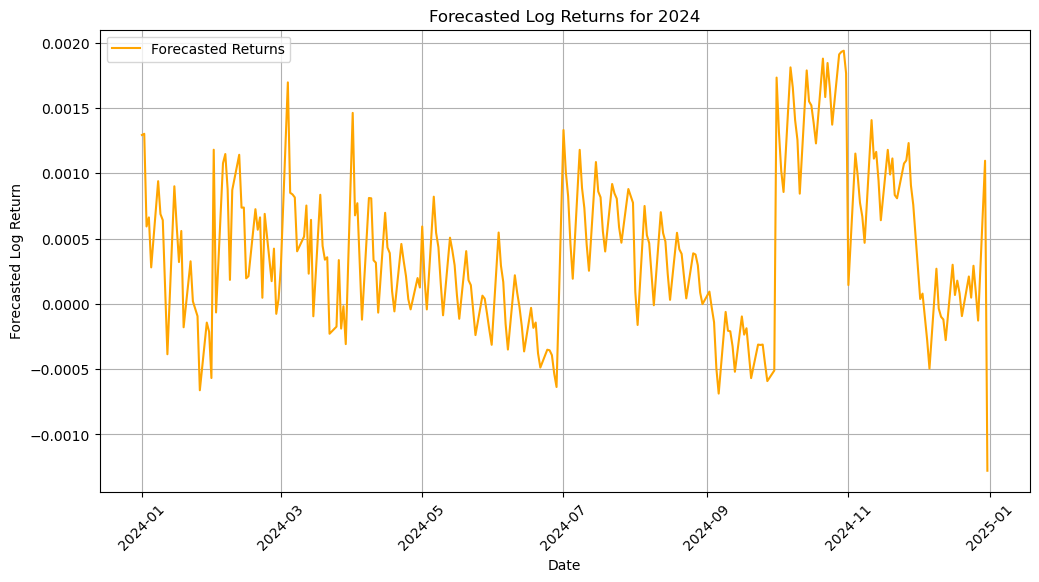

In [14]:
def run_workflow(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        #data = yf.download(ticker, start="2000-01-01", end="2023-12-31", auto_adjust=True)
        #data.columns = data.columns.get_level_values(0)
        #data = data.drop(columns={'High', 'Low', 'Open', 'Volume'})
        data = load_etf_data(ticker, start_date="2000-01-01", end_date="2023-12-31")
        print(data.head(1))
        print(data.columns)
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions, model_metrics = main(data, ticker)
        
        plot_forecasted_returns(future_predictions)
        
        # Step 6: Group forecasted returns month-wise and week-wise for 2024
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2024)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']

# Execute the workflow for multiple tickers
results = run_workflow(tickers)

## This is to load existing artifacts in a workflow

In [ ]:
# Step 7: Main Function
def main_load(data, ticker):
    max_lag = 80
    windows = [5,10,50]

    paths = build_artifact_paths(ticker)
    
    # Load Artifacts 
    print(f"Loading best params and scalers for: {ticker}")
    loaded_artifacts = load_artifacts(paths)
    best_params_loaded, feature_scaler_loaded, target_scaler_loaded, poly_loaded, svd_loaded, feature_cols_loaded = loaded_artifacts

        
    # Train Final Model on Full Dataset (`2000-2023`)
    final_model = train_final_model(data, max_lag, windows, feature_scaler_loaded, target_scaler_loaded, 
                      poly_loaded, svd_loaded, feature_cols_loaded, best_params_loaded)
    
    # Forecast Future (`2024`)
    future_predictions = forecast_future(data, final_model, feature_scaler_loaded, target_scaler_loaded, poly_loaded, svd_loaded, feature_cols_loaded, max_lag, windows, start_date="2024-01-01", end_date="2024-12-31" )

    print("Future Predictions:")
    print(future_predictions)
    
    return final_model, future_predictions

In [ ]:
def run_workflow_load(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        #data = yf.download(ticker, start="2000-01-01", end="2023-12-31", auto_adjust=True)
        #data.columns = data.columns.get_level_values(0)
        #data = data.drop(columns={'High', 'Low', 'Open', 'Volume'})
        data = load_etf_data(ticker, start_date="2000-01-01", end_date="2023-12-31")
        print(data.head(1))
        print(data.columns
             )
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions = main_load(data, ticker)
        
        plot_forecasted_returns(future_predictions)
        
        # Step 6: Group forecasted returns month-wise and week-wise for 2024
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2024)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            #"model_metrics": model_metrics
        }
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']

# Execute the workflow for multiple tickers
results = run_workflow_load(tickers)

### Method to define overview of the metrics and plot the same

Overall mean Training MAE: 0.0116
Overall mean Test MAE: 0.0143
Overall mean Training RMSE: 0.0164
Overall mean Test RMSE: 0.0197
Overall mean Training MASE: 0.69
Overall mean Test MASE: 0.70
Total time elapsed to run the model: 79.47 seconds
Average time consumed by model to train on an ETF: 7.95 seconds


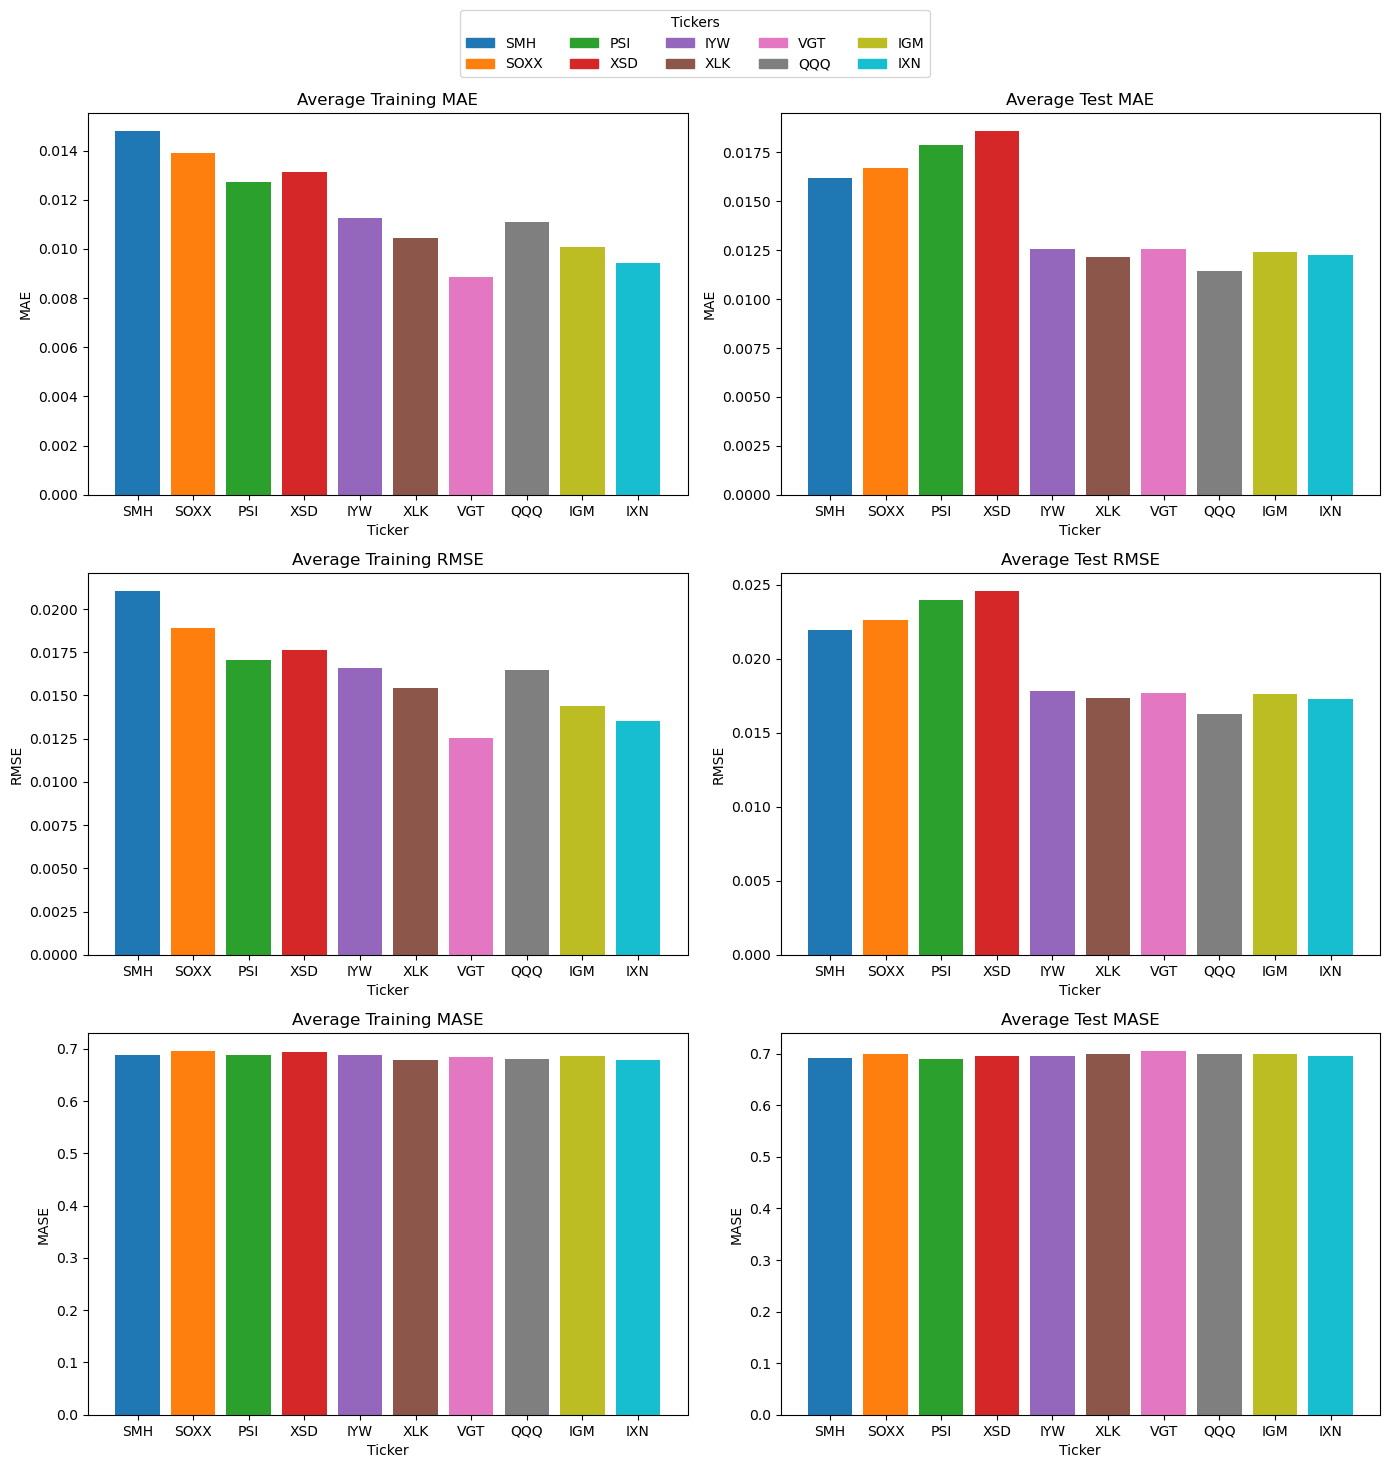

In [15]:
def plot_model_metrics(tickers, results):
    """
    Plots model performance metrics (MAE, RMSE, and MASE) for training and test sets.
    
    Parameters:
    - tickers: List of tickers.
    - results: Dictionary containing model metrics for each ticker.
    """
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []
    avg_training_mase = []
    avg_test_mase = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))
        avg_training_mase.append(train_set.get("mase", float('nan')))
        avg_test_mase.append(test_set.get("mase", float('nan')))

        computation_time.append(model_metrics.get("time", float('nan'))) 
    
    # Print global averages
    print(f"Overall mean Training MAE: {mean(avg_training_mae):.4f}")
    print(f"Overall mean Test MAE: {mean(avg_test_mae):.4f}")
    print(f"Overall mean Training RMSE: {mean(avg_training_rmse):.4f}")
    print(f"Overall mean Test RMSE: {mean(avg_test_rmse):.4f}")
    print(f"Overall mean Training MASE: {mean(avg_training_mase):.2f}")
    print(f"Overall mean Test MASE: {mean(avg_test_mase):.2f}")
    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds")
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds")

    # --- 2. Define a color palette ---
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]

    # --- 3. Set up a 3×2 subplot grid ---
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 5: Average Training MASE ---
    ax = axs[2, 0]
    ax.bar(x_positions, avg_training_mase, color=colors[:len(tickers)])
    ax.set_title("Average Training MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 6: Average Test MASE ---
    ax = axs[2, 1]
    ax.bar(x_positions, avg_test_mase, color=colors[:len(tickers)])
    ax.set_title("Average Test MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))
    )

    plt.show()

plot_model_metrics(tickers, results)

### Computation of Perfomance Metrics
- Rachev, Sharpe and Sortino Ratio
- Volatility clustering

In [16]:
def calculate_sharpe_ratio(returns, risk_free_rate_annual=0.1):
    """
    Diagnostic Sharpe Ratio function to print intermediate steps and identify issues.
    
    Parameters:
    - returns (numpy array or list): Array of daily log returns (already partitioned).
    - risk_free_rate_annual (float): Annualized risk-free rate. Default is 3% (0.03).
    
    Returns:
    - sharpe_ratio (float): The Sharpe Ratio.
    """
    # Convert list to numpy array if necessary
    returns = np.array(returns)
    
    # Adjust risk-free rate for daily frequency
    risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1 / 252) - 1
    
    # Calculate excess returns using daily risk-free rate
    excess_returns = returns - risk_free_rate_daily
    
    # Calculate mean of excess returns
    mean_excess_return = np.mean(excess_returns)
    
    # Calculate unbiased standard deviation using the corrected formula
    k = len(returns)
    mean_return = np.mean(returns)
    
    # Using the alternative unbiased standard deviation formula from the image
    variance = (np.sum(returns**2) / (k - 1)) - (k / (k - 1)) * (mean_return**2)
    std_dev = np.sqrt(variance) if variance > 0 else 0  # Avoid negative sqrt
    
    # **Adjust standard deviation for annualization** (scaling by sqrt(252))
    adjusted_std_dev = std_dev * np.sqrt(252)
    
   
    # Calculate Sharpe Ratio using adjusted standard deviation
    sharpe_ratio = mean_excess_return / adjusted_std_dev if adjusted_std_dev != 0 else 0  # Avoid division by zero
    
    return sharpe_ratio

def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95, epsilon=1e-6):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES) for the left tail (worst-case scenarios)
    if np.any(sorted_returns <= lower_threshold):
        es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    else:
        es = 0  # To handle cases where no returns fall in the left tail
    
    # Step 4: Calculate Expected Gain (EG) for the right tail (best-case scenarios)
    if np.any(sorted_returns >= upper_threshold):
        eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    else:
        eg = 0  # To handle cases where no returns fall in the right tail
    
    # Step 5: Compute the Rachev Ratio with epsilon to prevent division by zero
    es = abs(es) if es != 0 else epsilon  # Replace zero ES with epsilon
    rachev_ratio = eg / es  # No need for abs(es) since zero is replaced with epsilon
    
    return rachev_ratio


def calculate_volatility_clustering(returns, lag=1):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    
    # Handle empty input case
    if len(returns) == 0 or len(returns) <= lag:
        return None  # Return None if not enough data points

    abs_returns = np.abs(returns)  # Use absolute returns as per formula
    
     

    # Compute Pearson correlation between |r_t| and |r_{t+lag}|
    correlation_matrix = np.corrcoef(abs_returns[:-lag], abs_returns[lag:])
    clustering = correlation_matrix[0, 1]  # Extract correlation coefficient
    
    if np.isnan(clustering):
        return 0.0 
    return clustering


def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )

    epsilon = 1e-8

    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


### Compute Composite Scores by using SLSQP problem

In [17]:
def calculate_composite_score_optimized(
    forecasted_values, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)
    
    # Metrics in an array
    metrics = np.array([rachev_normalized, sharpe_normalized, sortino_normalized, -volatility_clustering_normalized])
    
    # Objective function: maximize risk-adjusted composite score
    def objective(weights):
        composite_score = np.dot(weights, metrics)  # Weighted sum
        risk = np.std(metrics * weights)  # Risk adjustment
        return -composite_score / (risk + epsilon)  # Negative for minimization
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: Each weight between 0 and 1
    bounds = [(0, 1) for _ in range(len(metrics))]
    
    # Initial equal weighting
    initial_weights = np.array([0.25, 0.25, 0.25, 0.25])
    
    # Optimization
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    # Compute final optimized composite score
    optimized_score = np.dot(optimized_weights, metrics)
    
    return optimized_score, optimized_weights

def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = score
    
    return composite_scores


In [18]:
#tickers = ['SMH', 'SOXX', 'PSI']
#results = run_workflow(tickers)
#risk_metrics_results = compute_risk_metrics(results)
#composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages=[0.01, 0.04, 0.1, 0.2])
#composite_scores

### Compute the scores for monthly horizons and plot the scores

In [19]:
def scores_monthly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a monthly basis.
    Return a dictionary of all ETF scores per month.
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per month
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    months = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[month].get(ticker, None) for month in months] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(20, 8))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(months, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(months)), labels=months[::1], rotation=45)

    plt.title("Composite Scores for Tickers Over Months")
    plt.xlabel("Months (1-month intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_monthly(results, return_scores=False)



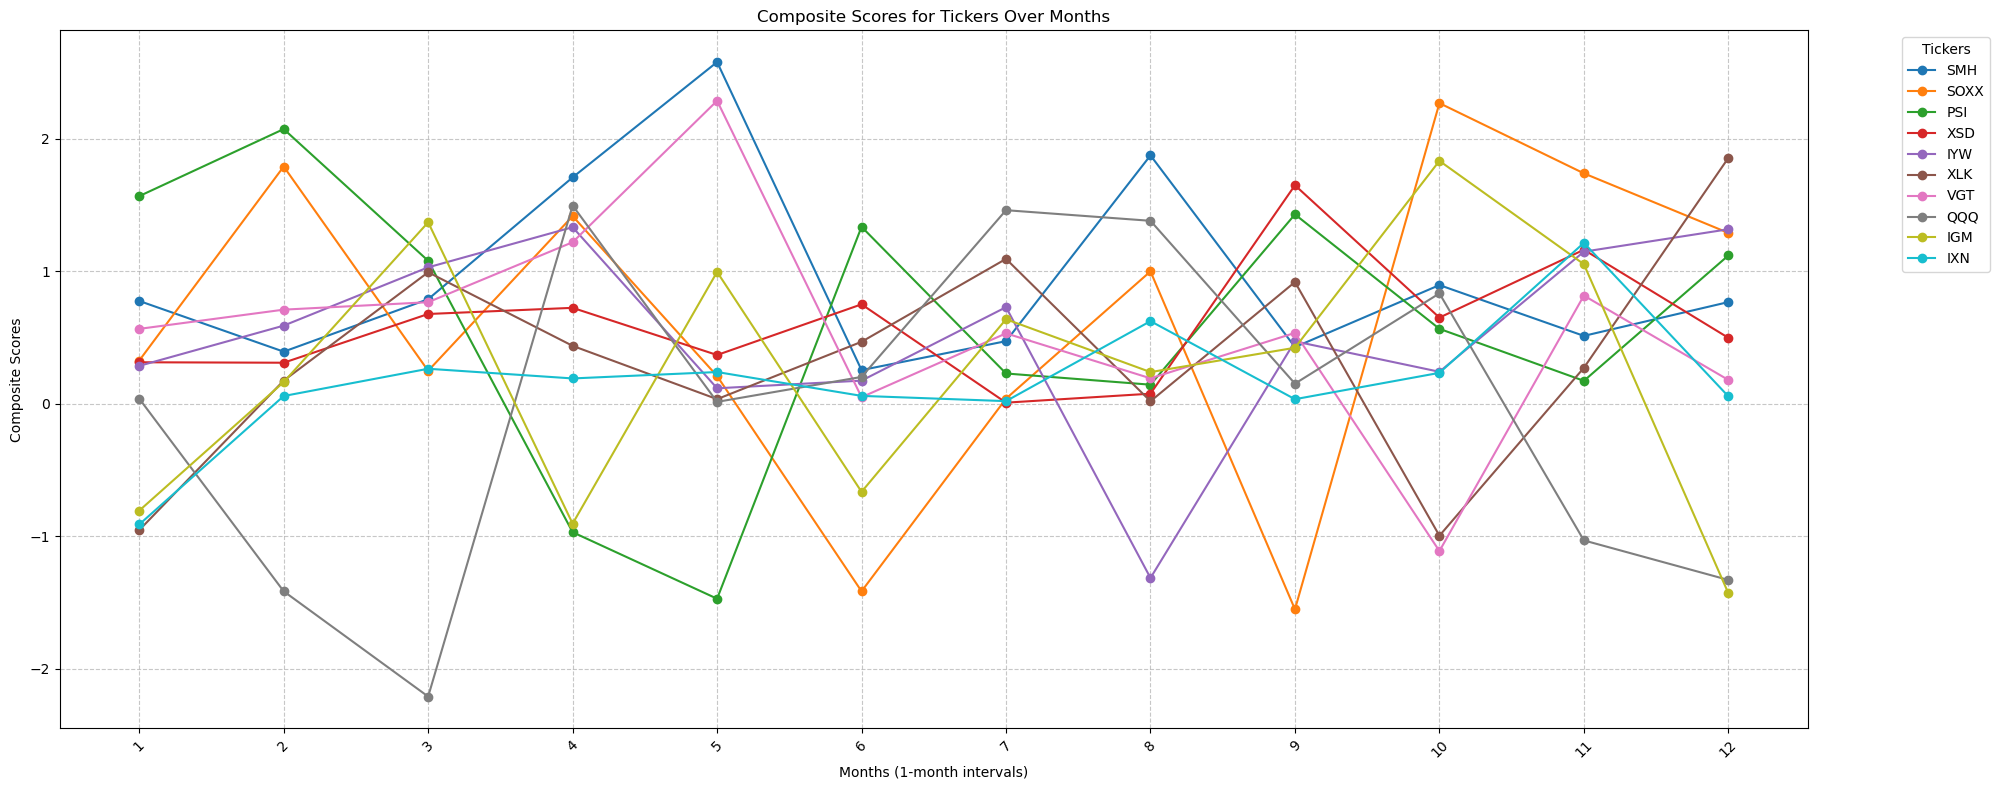

In [20]:
plot_composite_scores(scores, tickers)

### Methods for portfolio optimization of monthly horizon

In [21]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            #etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            #etf_data.columns = etf_data.columns.get_level_values(0)
            etf_data = load_etf_data(ticker, start_date, end_date)

            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = round((investment_amount * 0.9975) / price, 6)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = round(shares * price * 0.9975, 6)
            #print("(", shares ,"* ",price," * 0.9975")
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(sorted(etfs_to_buy), sorted(etfs_to_sell)):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = round((selling_values[etf_to_sell] * 0.9975) / price, 6)
            #print("(", selling_values[etf_to_sell], " * 0.9975) /", price)
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

In [22]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month


def portfolio_optimization(results, smoothing=False):
    all_scores = portfolio(results, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2025-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2025-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            #data = yf.download(ticker, start=month_13_start, end=month_13_end)
            #data.columns = data.columns.get_level_values(0)
            data = load_etf_data(ticker, month_13_start, month_13_end)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = round(sum(etf_values_13m.values()), 2) if etf_values_13m else 0

    return ticker_shares_per_month, total_portfolio_value


### Portfolio Optimization with and without smoothing enabled

In [23]:

portfolios, final_value = portfolio_optimization(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.7759389885747371, 'SOXX': 0.32613865442121515, 'PSI': 1.5670674671194513, 'XSD': 0.313279773699261, 'IYW': 0.28601823414912403, 'XLK': -0.9534307222400821, 'VGT': 0.5652803269020065, 'QQQ': 0.03887201749394023, 'IGM': -0.8064998495686678, 'IXN': -0.9109069669712234}
Month 2: {'SMH': 0.3932811564625091, 'SOXX': 1.7904548195444736, 'PSI': 2.073158061286043, 'XSD': 0.3098280476296961, 'IYW': 0.5897607791916619, 'XLK': 0.1748794618672542, 'VGT': 0.7103283945805797, 'QQQ': -1.4151970031759677, 'IGM': 0.16367452411992137, 'IXN': 0.05853657983236757}
Month 3: {'SMH': 0.7893212655130147, 'SOXX': 0.2489321726576449, 'PSI': 1.0791368056580857, 'XSD': 0.6776372674063477, 'IYW': 1.0297195907705887, 'XLK': 0.9924954118909138, 'VGT': 0.7665862629575771, 'QQQ': -2.209535040286467, 'IGM': 1.3696316285792214, 'IXN': 0.2643155062395591}
Month 4: {'SMH': 1.70852038776856, 'SOXX': 1.416237816765469, 'PSI': -0.9691537664081833, 'XSD': 0.72404714833192

In [24]:

portfolios, final_value = portfolio_optimization(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.7759389885747371, 'SOXX': 0.32613865442121515, 'PSI': 1.5670674671194513, 'XSD': 0.313279773699261, 'IYW': 0.28601823414912403, 'XLK': -0.9534307222400821, 'VGT': 0.5652803269020065, 'QQQ': 0.03887201749394023, 'IGM': -0.8064998495686678, 'IXN': -0.9109069669712234}
Month 2: {'SMH': 0.3932811564625091, 'SOXX': 1.7904548195444736, 'PSI': 2.073158061286043, 'XSD': 0.3098280476296961, 'IYW': 0.5897607791916619, 'XLK': 0.1748794618672542, 'VGT': 0.7103283945805797, 'QQQ': -1.4151970031759677, 'IGM': 0.16367452411992137, 'IXN': 0.05853657983236757}
Month 3: {'SMH': 0.7893212655130147, 'SOXX': 0.2489321726576449, 'PSI': 1.0791368056580857, 'XSD': 0.6776372674063477, 'IYW': 1.0297195907705887, 'XLK': 0.9924954118909138, 'VGT': 0.7665862629575771, 'QQQ': -2.209535040286467, 'IGM': 1.3696316285792214, 'IXN': 0.2643155062395591}
Month 4: {'SMH': 1.70852038776856, 'SOXX': 1.416237816765469, 'PSI': -0.9691537664081833, 'XSD': 0.72404714833192

### Compute the scores for weekly horizons and plot the scores

In [25]:
def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 54):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results
###
def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }

        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = score
    
    return composite_scores


In [26]:
def scores_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week
import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    weeks = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[week].get(ticker, None) for week in weeks] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(30, 14))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(weeks, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(weeks), 4), labels=weeks[::4], rotation=45)

    plt.title("Composite Scoares for Tickers Over Weeks")
    plt.xlabel("Weeks (4-week intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_weekly(results,return_scores=False)



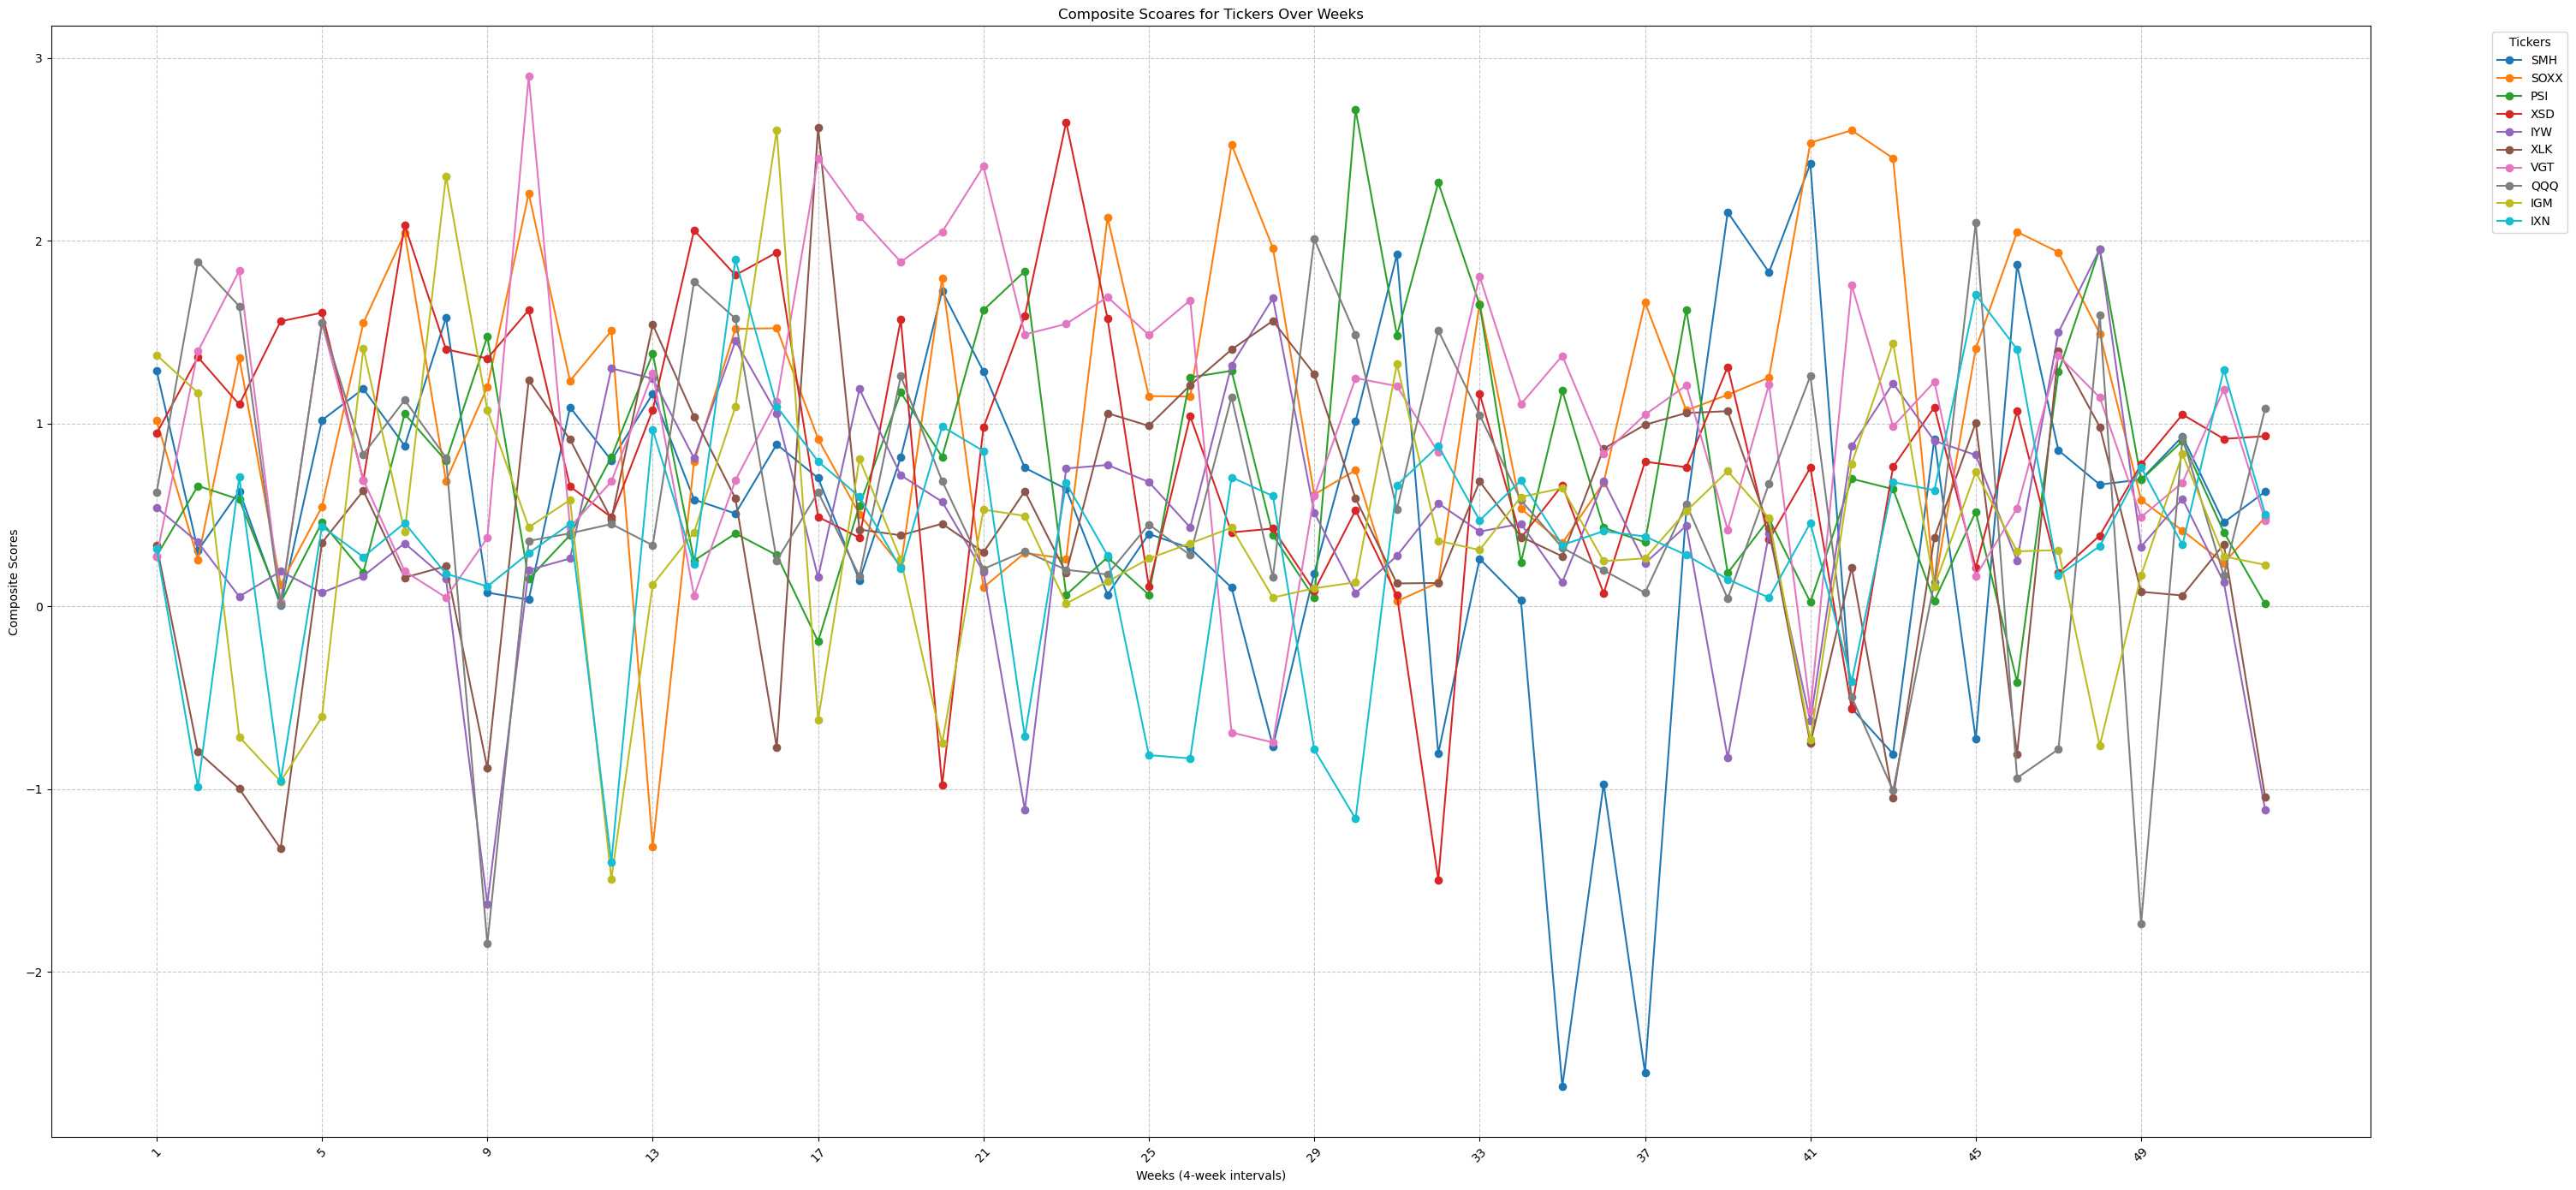

In [27]:
plot_composite_scores(scores, tickers)


### Methods for portfolio optimization of weekly horizon

In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            #etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            #etf_data.columns = etf_data.columns.get_level_values(0)
            etf_data = load_etf_data(ticker, start_date, end_date)

            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = round((investment_amount * 0.9975) / price, 6)  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
            
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            
            selling_values[etf] = round(shares * price * 0.9975, 6)
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(sorted(etfs_to_buy), sorted(etfs_to_sell)):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = round((selling_values[etf_to_sell] * 0.9975) / price, 6)
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [29]:
def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2025-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2025-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            #data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            #data.columns = data.columns.get_level_values(0)
            data = load_etf_data(ticker, week_53_start, week_53_end)
            
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = round(sum(etf_values_53w.values()), 2) if etf_values_53w else 0    
    
    return ticker_shares_per_week, total_portfolio_value


### Portfolio Optimization with and without smoothing enabled

In [30]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 1.289479488094296, 'SOXX': 1.0158686603567617, 'PSI': 0.27433847720008514, 'XSD': 0.9452497127890849, 'IYW': 0.5398822584000542, 'XLK': 0.33360590652052985, 'VGT': 0.27322659408056466, 'QQQ': 0.6228098196464926, 'IGM': 1.374852366752195, 'IXN': 0.3155868217410212}
Week 2: {'SMH': 0.30512494785080807, 'SOXX': 0.2552167126072668, 'PSI': 0.6585653470639526, 'XSD': 1.362506048906064, 'IYW': 0.3498623505680148, 'XLK': -0.7964250358322303, 'VGT': 1.39535563297906, 'QQQ': 1.8856569946366433, 'IGM': 1.1677186874044805, 'IXN': -0.989493759927701}
Week 3: {'SMH': 0.630403542356731, 'SOXX': 1.3588685795395556, 'PSI': 0.5845505733145743, 'XSD': 1.1038795568721076, 'IYW': 0.052801439737775534, 'XLK': -0.9988619662588504, 'VGT': 1.8363879917135897, 'QQQ': 1.641759769358714, 'IGM': -0.7155275975580249, 'IXN': 0.7067170323292239}
Week 4: {'SMH': 0.003736771980513081, 'SOXX': 0.11843583675475744, 'PSI': 0.019956197190179575, 'XSD': 1.559325573862708,

Buy IGM: 687.78 shares at 72.52.
Buy SMH: 296.48 shares at 168.22.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IGM', 'SMH']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'SMH']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'IGM': 687.77651, 'SMH': 296.478996}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'SMH']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'SMH']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IGM': 687.77651, 'SMH': 296.478996}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'SMH']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['XSD', 'SMH']
Sell IGM: 687.78 shares at 78.42. Total value: 53802.40
Buy XSD: 239.58 shares at 224.01.
Updated ticker shares after 2024-01-22 to 2024-01-28: {'SMH': 296.478996, 'XSD': 239.580032}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['XSD', 'SMH']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['XSD', 'SMH']
Updated ticker shares after 2024-01-29 to 2024-02-04: {'XSD': 239.580032, 'SMH': 296.478996}
Top 2 ETFs for 2024-01-29

In [31]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 1.289479488094296, 'SOXX': 1.0158686603567617, 'PSI': 0.27433847720008514, 'XSD': 0.9452497127890849, 'IYW': 0.5398822584000542, 'XLK': 0.33360590652052985, 'VGT': 0.27322659408056466, 'QQQ': 0.6228098196464926, 'IGM': 1.374852366752195, 'IXN': 0.3155868217410212}
Week 2: {'SMH': 0.30512494785080807, 'SOXX': 0.2552167126072668, 'PSI': 0.6585653470639526, 'XSD': 1.362506048906064, 'IYW': 0.3498623505680148, 'XLK': -0.7964250358322303, 'VGT': 1.39535563297906, 'QQQ': 1.8856569946366433, 'IGM': 1.1677186874044805, 'IXN': -0.989493759927701}
Week 3: {'SMH': 0.630403542356731, 'SOXX': 1.3588685795395556, 'PSI': 0.5845505733145743, 'XSD': 1.1038795568721076, 'IYW': 0.052801439737775534, 'XLK': -0.9988619662588504, 'VGT': 1.8363879917135897, 'QQQ': 1.641759769358714, 'IGM': -0.7155275975580249, 'IXN': 0.7067170323292239}
Week 4: {'SMH': 0.003736771980513081, 'SOXX': 0.11843583675475744, 'PSI': 0.019956197190179575, 'XSD': 1.559325573862708,

Buy IGM: 687.78 shares at 72.52.
Buy SMH: 296.48 shares at 168.22.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IGM', 'SMH']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['QQQ', 'VGT']
Sell IGM: 687.78 shares at 73.52. Total value: 50441.24
Sell SMH: 296.48 shares at 171.20. Total value: 50630.67
Buy QQQ: 125.18 shares at 401.96.
Buy VGT: 107.36 shares at 470.41.
Updated ticker shares after 2024-01-08 to 2024-01-14: {'QQQ': 125.175019, 'VGT': 107.36239}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['QQQ', 'VGT']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['VGT', 'QQQ']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'QQQ': 125.175019, 'VGT': 107.36239}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['VGT', 'QQQ']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['XSD', 'IYW']
Sell VGT: 107.36 shares at 499.08. Total value: 53449.00
Sell QQQ: 125.18 shares at 418.61. Total value: 52269.06
Buy IYW: 406.65 shares at 128.22.
Buy XSD: 238.01 shares at 224.01.
Updated ticker shares after 2024-01-22 to 2024-01-